In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.svm import LinearSVC

import numpy as np

# 生成数据

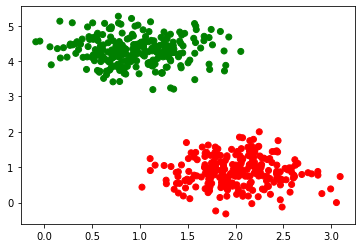

In [2]:
# Generate toy data that has two distinct classes and a huge gap between them
X, Y = make_blobs(n_samples=500, centers=2, random_state=0, cluster_std=0.4)  # X - features, Y - labels

# Plot the toy data
plt.scatter(x=X[:, 0], y=X[:, 1], c = ['r' if i == 1 else 'g' for i in Y])


Y[Y == 0] = -1  # Replace zeros with -1

# UDF

In [3]:
def visualize(model, X, Y, W, b):
    delta = 0.001
    x = np.arange(X[:, 0].min(), X[:, 0].max(), delta)
    y = np.arange(X[:, 1].min(), X[:, 1].max(), delta)
    x, y = np.meshgrid(x, y)
    xy = list(map(np.ravel, [x, y]))

    z = (W.dot(xy) + b).reshape(x.shape)
    z[np.where(z > 1.0)] = 4
    z[np.where((z > 0.0) & (z <= 1.0))] = 3
    z[np.where((z > -1.0) & (z <= 0.0))] = 2
    z[np.where(z <= -1.0)] = 1

    plt.figure(figsize=(7, 5))
    plt.xlim([X[:, 0].min() + delta, X[:, 0].max() - delta])
    plt.ylim([X[:, 1].min() + delta, X[:, 1].max() - delta])
    plt.contourf(x, y, z, alpha=0.8, cmap="Greys")
    plt.scatter(x=X[:, 0], y=X[:, 1], c="black", s=10)
    plt.tight_layout()
    plt.show()

# 定义模型

In [4]:
class LinearSVM(nn.Module):
    def __init__(self):
        super(LinearSVM, self).__init__()
        self.linear = nn.Linear(2, 1)
    def forward(self, x):
        y = self.linear(x)
        return y
    
svm = LinearSVM()
optimizer = optim.SGD(svm.parameters(), lr=0.1)

batch_size = 1
epoch_num = 30
N = 500

X_train = (X - X.mean()) / X.std()

svm.train()

for epoch in range(1,epoch_num+1):
    sum_loss = 0
    for i in range(0, N, batch_size):
        x = torch.Tensor(X[i: i+batch_size])
        y = torch.Tensor(Y[i: i+batch_size])
        
        y_pred = svm(x)

        loss = torch.mean(torch.clamp(1 - y_pred * y, min=0))       # hinge loss
        loss += 0.01 * torch.mean(svm.linear.weight ** 2) / 2       # l2 pently

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        
        sum_loss += loss.detach().numpy()
    if epoch % 10 == 0:
        print('Epoch:', epoch, 'Loss:', sum_loss)


Epoch: 10 Loss: 4.47246565297246
Epoch: 20 Loss: 3.5527156880125403
Epoch: 30 Loss: 3.469218038022518


[ 0.52753496 -1.2810394 ] 2.6056826


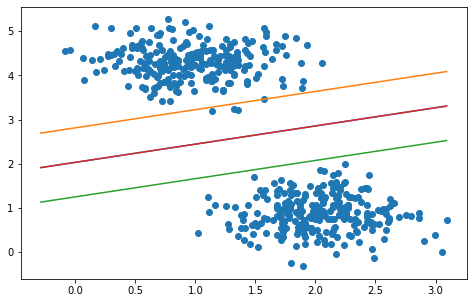

In [5]:
w = svm.linear.weight[0].detach().numpy()
b = svm.linear.bias[0].detach().numpy()

delta = 0.001
x = np.arange(X[:, 0].min()-0.2, X[:, 0].max(), delta)

plt.figure(figsize=(8, 5))
plt.scatter(x=X[:, 0], y=X[:, 1])

'''
w0 * x + w1 *y + b = 0
w0 * x + w1 *y + b = 1
w0 * x + w1 *y + b = -1
'''
plt.plot(x,(w[0]*x  + b)/ (-w[1]) )

plt.plot(x,(w[0]*x  + b + 1)/ (-w[1]))

plt.plot(x,(w[0]*x  + b - 1)/ (-w[1]))

y = -w[0]/w[1] * x - b/w[1]  # 套方程公式
plt.plot(x, y)

 
print(w, b)

[ 0.52753496 -1.2810394 ] 2.6056826


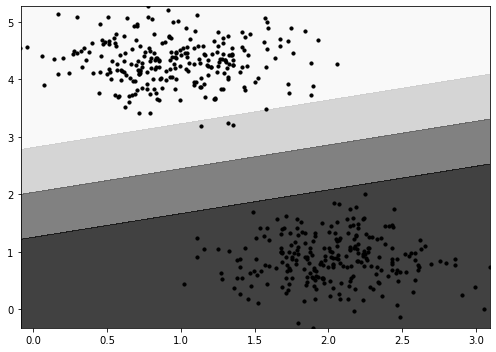

In [6]:
W = svm.linear.weight[0].detach().numpy()
b = svm.linear.bias[0].detach().numpy()    
print(W, b)
visualize(svm, X, Y, W, b)

# Sklearn

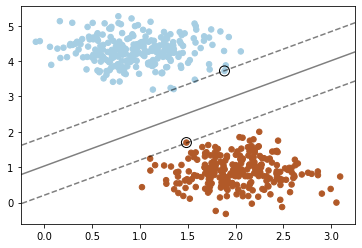

In [7]:
svc = LinearSVC(C=100, random_state=0, tol=1e-5)
svc.fit(X, Y)

decision_function = svc.decision_function(X)

support_vector_indices = np.where( np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = X[support_vector_indices]

plt.scatter(X[:, 0], X[:, 1], c=Y, s=30, cmap=plt.cm.Paired)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
Z = svc.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,  linewidth=1, facecolors='none', edgecolors='k')

[ 1.20553614 -1.21304586] [1.25182483]


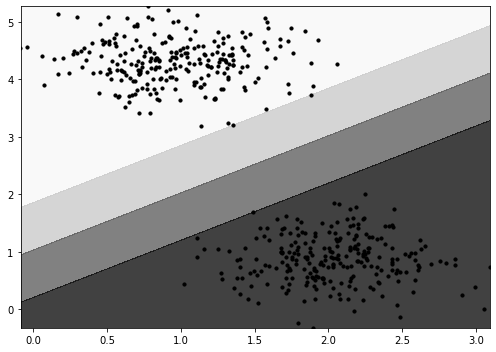

In [8]:
W, b = svc.coef_[0], svc.intercept_
print(W, b)
 
visualize(svm, X, Y, W, b)